In [3]:
import keras
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten
from keras.models import Sequential

2024-08-01 13:42:35.707577: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-01 13:42:35.707710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-01 13:42:35.818750: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Failed to read image: /kaggle/input/autismsmall/dataset/Autism/dataset.html
Failed to read image: /kaggle/input/autismsmall/dataset/Autism/dataset - Shortcut.lnk


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


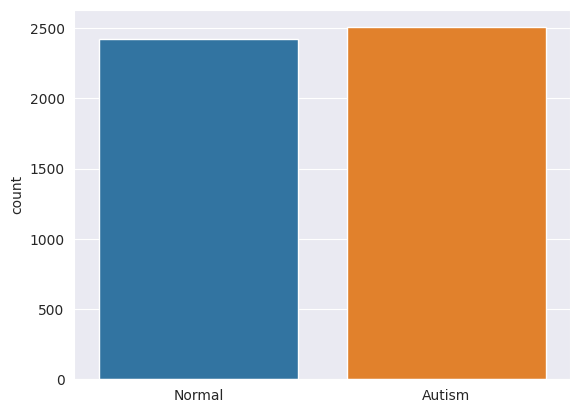

In [4]:
import cv2
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed

data_dir = r"/kaggle/input/autismsmall/dataset"
labels = ['Normal', 'Autism']
img_size = 256

def process_image(label, img, img_size):
    img_path = os.path.join(data_dir, label, img)
    img_arr = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    if img_arr is not None:
        img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)  # convert BGR to RGB format
        resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Resizing images
        class_num = labels.index(label)
        return resized_arr, class_num
    else:
        print(f"Failed to read image: {img_path}")
        return None

def get_data(data_dir):
    data = []
    with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        futures = []
        for label in labels:
            path = os.path.join(data_dir, label)
            for img in os.listdir(path):
                futures.append(executor.submit(process_image, label, img, img_size))

        for future in as_completed(futures):
            result = future.result()
            if result is not None:
                data.append(result)

    return data

# Load data from the dataset directory
data = get_data(data_dir)

# Prepare labels for visualization
labels_list = ['Normal' if item[1] == 0 else 'Autism' for item in data]

# Visualize the distribution of labels
sns.set_style('darkgrid')
sns.countplot(x=labels_list)
plt.show()


In [5]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


images, labels_list = zip(*data)

# Convert to numpy arrays
images = np.array(images)
# Ensure labels are one-hot encoded
labels_list = to_categorical(labels_list, num_classes=2)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels_list, test_size=0.2, random_state=42)

In [6]:
print(y_train)

[[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [7]:
model=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(256,256,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2,activation='softmax')


])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
import tensorflow as tf
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 128)    │        46,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 31, 31, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 31, 31, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     6,554,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,198,594 (35.09 MB)

 Trainable params: 9,196,290 (35.08 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [9]:
train_ds=tf.data.Dataset.from_tensor_slices((X_train,y_train))
test_ds=tf.data.Dataset.from_tensor_slices((X_val,y_val))

In [10]:
def process_image(image,label):
    image=tf.image.per_image_standardization(image)
    image=tf.image.resize(image,(256, 256))

    return image,label

In [11]:
train_ds_size=tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size=tf.data.experimental.cardinality(test_ds).numpy()
print('Train size:',train_ds_size)
print('Test size:',test_ds_size)

Train size: 3943
Test size: 986


In [12]:
train_ds=(train_ds
          .map(process_image)
          .shuffle(buffer_size=train_ds_size)
          .batch(batch_size=32,drop_remainder=True)
         )
test_ds=(test_ds
          .map(process_image)
          .shuffle(buffer_size=test_ds_size)
          .batch(batch_size=32,drop_remainder=True)
         )

In [13]:
model.compile(loss=keras.metrics.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [14]:
history=model.fit(
    train_ds,
    epochs=38,
    validation_data=test_ds,
    validation_freq=1,
    batch_size=128
)

Epoch 1/38
  3/123 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.4722 - loss: 9.5919 

I0000 00:00:1722519852.831756     658 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1722519852.858806     658 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5308 - loss: 2.9486

W0000 00:00:1722519858.715059     658 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


123/123 ━━━━━━━━━━━━━━━━━━━━ 26s 52ms/step - accuracy: 0.5310 - loss: 2.9367 - val_accuracy: 0.5406 - val_loss: 0.7473
Epoch 2/38
123/123 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.5946 - loss: 0.6795 - val_accuracy: 0.5938 - val_loss: 0.6572
Epoch 3/38
123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.5797 - loss: 0.6653 - val_accuracy: 0.6219 - val_loss: 0.6278
Epoch 4/38
123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.6072 - loss: 0.6563 - val_accuracy: 0.5969 - val_loss: 0.6476
Epoch 5/38
123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.5790 - loss: 0.6574 - val_accuracy: 0.5833 - val_loss: 0.6410
Epoch 6/38
123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.6019 - loss: 0.6347 - val_accuracy: 0.6448 - val_loss: 0.6244
Epoch 7/38
123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.6122 - loss: 0.6422 - val_accuracy: 0.6302 - val_loss: 0.6265
Epoch 8/38
123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.6094 - loss: 0.6376 - val_accuracy: 0.60

In [15]:
model.history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

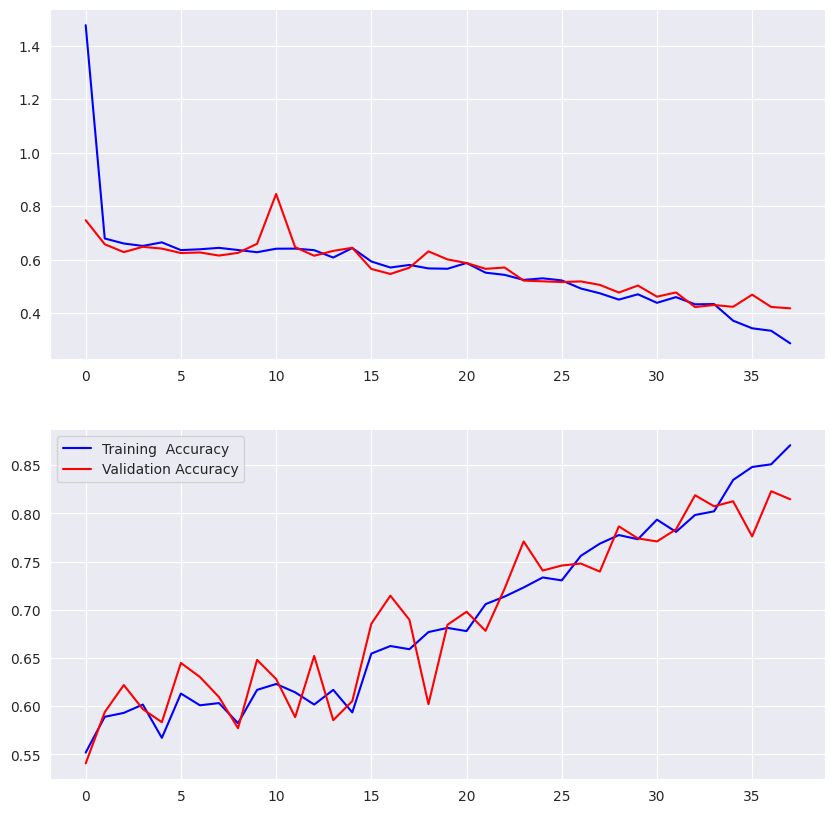

In [16]:
import matplotlib.pyplot as plt
f,ax=plt.subplots(2,1,figsize=(10,10))

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(model.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()

In [17]:
print('Accuracy Score = ',np.max(history.history['val_accuracy']))

Accuracy Score =  0.8229166865348816
